In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## PASCAL VOC data setup

In [4]:
# BASE_PATH = '/content/drive/MyDrive/ai/detection/detection-tutorial/'
BASE_PATH = '/content/drive/MyDrive/ai/detection/'

In [5]:
!ls {BASE_PATH}

detection_setup.ipynb  detectron2_test.ipynb
detection-tutorial     VOCtrainval_11-May-2012.tar


In [6]:
file = BASE_PATH + 'VOCtrainval_11-May-2012.tar'

In [7]:
%%time
!cp {file} .

CPU times: user 327 ms, sys: 64.7 ms, total: 392 ms
Wall time: 1min 10s


In [8]:
%%time
!tar -xvf ./VOCtrainval_11-May-2012.tar > /dev/null

CPU times: user 258 ms, sys: 33.3 ms, total: 292 ms
Wall time: 55.4 s


In [9]:
!pwd

/content


In [10]:
!ls

drive  sample_data  VOCdevkit  VOCtrainval_11-May-2012.tar


In [11]:
!mkdir ./pascal-voc

## Imports

In [186]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
import os
import numpy as np
import torch

In [15]:
os.chdir("drive/My Drive/ai/detection/detection-tutorial")
# os.chdir("/content/")

In [16]:
!ls

dataset			  loss.py      train.py       utils.py
detection-tutorial.ipynb  pascal-voc   transfroms.py
faster_rcnn.py		  __pycache__  utils_plot.py


In [17]:
# import sys
# sys.path.append('./dataset/')
# sys.path.append('./')
# sys.path

In [155]:
from transforms import get_transform

import time
from utils import format_time
from utils import generate_anchors, process_anchors, find_jaccard_overlap
from utils_plot import show_image_and_bb, show_anchors, show_image_from_dataset

from loss import BoxLoss
from train import run_loader, get_device

In [145]:
from dataset.pascal_voc_utils import create_data_lists
create_data_lists(
    voc07_path=None,
#     voc12_path='/content/VOCdevkit/VOC2012/',
    voc12_path='../VOCdevkit/VOC2012/',
    output_folder='./pascal-voc/'
)


There are 11540 training images containing a total of 34620 objects. Files have been saved to /Users/michaelka/Developer/ml/projects/detection/detection-tutorial/pascal-voc.


## PennFudanDataset

In [ ]:
from dataset.penn_fudan_dataset import PennFudanDataset

In [ ]:
# dataset = PennFudanDataset('../PennFudanPed', get_transform(train=False))
dataset = PennFudanDataset('../PennFudanPed', None)

In [ ]:
image, target = dataset[0]

In [ ]:
type(image)

PIL.Image.Image

In [ ]:
target

{'boxes': tensor([[159., 181., 301., 430.],
         [419., 170., 534., 485.]]),
 'labels': tensor([1, 1])}

tensor([159., 181., 301., 430.])
tensor([419., 170., 534., 485.])


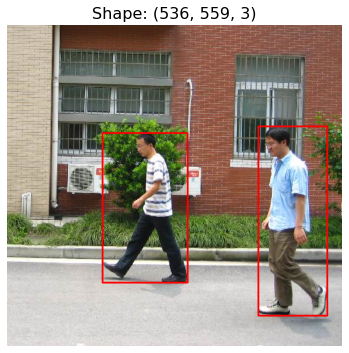

In [ ]:
# show_image(dataset, 0)
show_image_and_bb(image, target)

In [ ]:
anchors = generate_anchors()

In [ ]:
# anchors = anchors[:5]
anchors.shape

torch.Size([441, 4])

In [ ]:
# each anchor we need to match gt_box and binary label - positive
# or 0 label and no box - negative

# We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes.
# Anchors that are neither positive nor negative do not contribute to the training objective.

# + add delatas for loss

In [ ]:
anchor_labels, gt_offsets = process_anchors(anchors, target['boxes'])

In [ ]:
def get_top_n_anchors(anchors, gt_boxes):
    # anchors (N1, 4)
    # gt_boxes (N2, 4)
 
    jaccard = find_jaccard_overlap(anchors, gt_boxes) # (N1, N2)
    
    prior_max_iou, prior_gt_box_idx = jaccard.max(1) # (N1), (N1)
    
    top_n = 10
    _, top_priors_idx = prior_max_iou.sort(descending=True)
    return anchors[top_priors_idx[:top_n]], prior_max_iou[top_priors_idx[:top_n]]

In [ ]:
top_n_anchors, top_n_iou = get_top_n_anchors(anchors, target['boxes'])

In [ ]:
top_n_iou

tensor([0.4745, 0.4732, 0.4732, 0.4691, 0.4008, 0.3733, 0.3733, 0.3644, 0.3631,
        0.3602])

In [ ]:
N = 9
start = 24
# show_anchors(image, target['boxes'], anchors[start*N:(start+1)*N])
# show_anchors(image, target['boxes'], anchors)

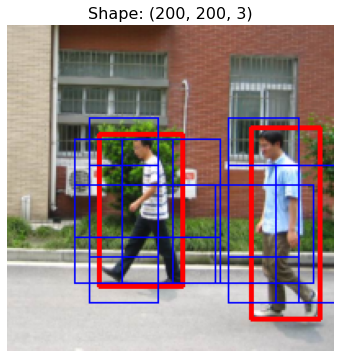

In [ ]:
show_anchors(image, target['boxes'], top_n_anchors)

## PASCAL VOC dataset

In [142]:
from dataset.pascal_voc_dataset import PascalVOCDataset

In [157]:
# dataset = PascalVOCDataset('/content/pascal-voc/', 'TRAIN', get_transform(train=True))
dataset = PascalVOCDataset('./pascal-voc/', 'TRAIN', get_transform(train=True))

In [148]:
image, target = dataset[3]

In [149]:
target

{'boxes': tensor([[0.1040, 0.1946, 0.9400, 0.9480],
         [0.3140, 0.0973, 0.5760, 0.3756]]),
 'labels': tensor([13, 15]),
 'difficulties': tensor([0, 0], dtype=torch.uint8)}

tensor([ 20.8000,  38.9140, 188.0000, 189.5928])
tensor([ 62.8000,  19.4570, 115.2000,  75.1131])
Shape: (200, 200, 3)


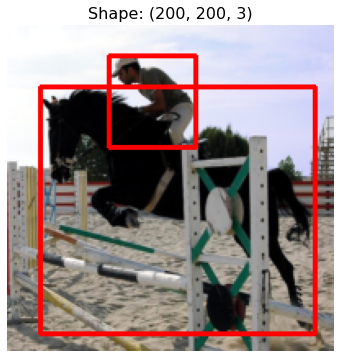

In [195]:
show_image_and_bb(image, target['boxes'])

## Test Model

In [26]:
def collate_fn(batch):
    # batch: list[tuple]
    # each tuple is (image, target) dictionary
    # turns it into a single tuple (in this case of len == 2)
    
    # TODO: why it's always tuple  
    # print(f'collate_fn, {len(batch)}, {list(zip(*batch))[0]}, {type(list(zip(*batch))[0])}')
    # return list(zip(*batch))
    
    # torch.stack here? for images?
    # do we distinguish targets between images?
    
    return tuple(zip(*batch))

In [27]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

In [67]:
images, targets = next(iter(data_loader))
# images = next(iter(data_loader))

/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:47: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  boxes = boxes[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:48: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  labels = labels[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:49: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  difficulties = difficulties[1 - difficulties]


In [68]:
type(images), type(targets)

(tuple, tuple)

In [69]:
images = torch.stack(images, dim=0)

In [70]:
images.shape

torch.Size([8, 3, 200, 200])

In [71]:
# targets

In [29]:
from faster_rcnn import faster_rcnn

In [73]:
net = faster_rcnn()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [74]:
offsets, labels = net(images)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [75]:
offsets.shape, labels.shape

(torch.Size([8, 441, 4]), torch.Size([8, 441, 1]))

In [80]:
device = get_device()

No GPU available, using the CPU instead.


In [81]:
criterion = BoxLoss(device)

In [82]:
loss = criterion(labels, offsets, targets)

In [83]:
loss

(tensor(2.5789, grad_fn=<AddBackward0>),
 tensor(1.8870, grad_fn=<L1LossBackward>),
 tensor(0.6919, grad_fn=<BinaryCrossEntropyWithLogitsBackward>))

In [84]:
np.log(1/2)

-0.6931471805599453

## Train Model

In [38]:
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
len(train_loader)

1443

In [39]:
params = {
    'learning_rate' : 0.001,
    'weight_decay'  : 0,
    'num_epoch'     : 2
}

model = faster_rcnn()

run_loader(model, train_loader, None, **params)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
[train] index:  0, loss(box/cls) = 2.51103(1.77640/0.73463) time: 0:00:00


/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:47: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  boxes = boxes[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:48: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  labels = labels[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:49: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  difficulties = difficulties[1 - difficulties]


[train] index: 100, loss(box/cls) = 2.08980(1.67377/0.41603) time: 0:00:07
[train] index: 200, loss(box/cls) = 1.53724(1.12103/0.41621) time: 0:00:14
[train] index: 300, loss(box/cls) = 1.54284(1.17414/0.36871) time: 0:00:20
[train] index: 400, loss(box/cls) = 1.33409(0.94387/0.39022) time: 0:00:27
[train] index: 500, loss(box/cls) = 1.23265(0.95894/0.27371) time: 0:00:34
[train] index: 600, loss(box/cls) = 1.47188(1.15760/0.31429) time: 0:00:41
[train] index: 700, loss(box/cls) = 1.38084(1.11081/0.27003) time: 0:00:48
[train] index: 800, loss(box/cls) = 1.13748(0.78485/0.35264) time: 0:00:54
[train] index: 900, loss(box/cls) = 1.44728(1.20427/0.24301) time: 0:01:01
[train] index: 1000, loss(box/cls) = 1.23932(0.86597/0.37335) time: 0:01:08
[train] index: 1100, loss(box/cls) = 0.96726(0.75159/0.21567) time: 0:01:14
[train] index: 1200, loss(box/cls) = 1.32545(1.02724/0.29821) time: 0:01:21
[train] index: 1300, loss(box/cls) = 1.23931(0.93166/0.30765) time: 0:01:28
[train] index: 1400, 

{}

## Main

In [85]:
from train import main

In [86]:
main()

run main
data size  all: 11540, train: 10386
data_loader_size train: 1299, valid: 145
No GPU available, using the CPU instead.


FileNotFoundError: ignored

## ipywidgets

In [205]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

In [230]:
# dataset = PascalVOCDataset('./pascal-voc/', transforms=get_transform(train=True))
dataset = PascalVOCDataset('./pascal-voc/')

get_transform_to_show


In [231]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(dataset),
    step=1,
    description='Image:',
    disabled=False
)

def handle_change(x):
    print(x)
    show_image_from_dataset(dataset, x, top_n_anchors=0)

In [232]:
# do it only once

# import json
# # with open('./pascal-voc/label_map.json'), 'r') as j:
# data_folder = './pascal-voc'
# with open(os.path.join(data_folder, 'label_map.json'), 'r') as j:
#     labels = json.load(j)

In [235]:
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=299, description='Image:', max=11540), Output()), _dom_classes=('wi…

<function __main__.handle_change(x)>

## Trainimg